In [36]:
import math
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import time

import datetime
from datetime import date
from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from tqdm import notebook
from xgboost import XGBRegressor
import joblib

%matplotlib inline

#### Input params ##################
stk_path = "./GOOG.csv"
test_size = 0.2                # proportion of dataset to be used as test set
cv_size = 0.2                  # proportion of dataset to be used as cross-validation set
N = 2                          # for feature at day t, we use lags from t-1, t-2, ..., t-N as features
time_window = 2

n_estimators = 100             # Number of boosted trees to fit. default = 100
max_depth = 3                  # Maximum tree depth for base learners. default = 3
learning_rate = 0.1            # Boosting learning rate (xgb’s “eta”). default = 0.1
min_child_weight = 1           # Minimum sum of instance weight(hessian) needed in a child. default = 1
subsample = 1                  # Subsample ratio of the training instance. default = 1
colsample_bytree = 1           # Subsample ratio of columns when constructing each tree. default = 1
colsample_bylevel = 1          # Subsample ratio of columns for each split, in each level. default = 1
gamma = 0                      # Minimum loss reduction required to make a further partition on a leaf node of the tree. default=0

model_seed = 100

fontsize = 14
ticklabelsize = 14
####################################

# Common functions

In [37]:
def get_mov_avg_std(df, col, N):
    """
    Given a dataframe, get mean and std dev at timestep t using values from t-1, t-2, ..., t-N.
    Inputs
        df         : dataframe. Can be of any length.
        col        : name of the column you want to calculate mean and std dev
        N          : get mean and std dev at timestep t using values from t-1, t-2, ..., t-N
    Outputs
        df_out     : same as df but with additional column containing mean and std dev
    """
    mean_list = df[col].rolling(window = N, min_periods=1).mean() # len(mean_list) = len(df)
    std_list = df[col].rolling(window = N, min_periods=1).std()   # first value will be NaN, because normalized by N-1
    
    # Add one timestep to the predictions
    mean_list = np.concatenate((np.array([np.nan]), np.array(mean_list[:-1])))
    std_list = np.concatenate((np.array([np.nan]), np.array(std_list[:-1])))
    
    # Append mean_list to df
    df_out = df.copy()
    df_out[col + '_mean'] = mean_list
    df_out[col + '_std'] = std_list
    
    return df_out

def scale_row(row, feat_mean, feat_std):
    """
    Given a pandas series in row, scale it to have 0 mean and var 1 using feat_mean and feat_std
    Inputs
        row      : pandas series. Need to scale this.
        feat_mean: mean  
        feat_std : standard deviation
    Outputs
        row_scaled : pandas series with same length as row, but scaled
    """
    # If feat_std = 0 (this happens if adj_close doesn't change over N days), 
    # set it to a small number to avoid division by zero
    feat_std = 0.001 if feat_std == 0 else feat_std
    
    row_scaled = (row-feat_mean) / feat_std
    
    return row_scaled

def get_mape(y_true, y_pred): 
    """
    Compute mean absolute percentage error (MAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def train_pred_eval_model(X_train_scaled, \
                          y_train_scaled, \
                          X_test_scaled, \
                          y_test, \
                          col_mean, \
                          col_std, \
                          seed=100, \
                          n_estimators=100, \
                          max_depth=3, \
                          learning_rate=0.1, \
                          min_child_weight=1, \
                          subsample=1, \
                          colsample_bytree=1, \
                          colsample_bylevel=1, \
                          gamma=0):
    '''
    Train model, do prediction, scale back to original range and do evaluation
    Use XGBoost here.
    Inputs
        X_train_scaled     : features for training. Scaled to have mean 0 and variance 1
        y_train_scaled     : target for training. Scaled to have mean 0 and variance 1
        X_test_scaled      : features for test. Each sample is scaled to mean 0 and variance 1
        y_test             : target for test. Actual values, not scaled.
        col_mean           : means used to scale each sample of X_test_scaled. Same length as X_test_scaled and y_test
        col_std            : standard deviations used to scale each sample of X_test_scaled. Same length as X_test_scaled and y_test
        seed               : model seed
        n_estimators       : number of boosted trees to fit
        max_depth          : maximum tree depth for base learners
        learning_rate      : boosting learning rate (xgb’s “eta”)
        min_child_weight   : minimum sum of instance weight(hessian) needed in a child
        subsample          : subsample ratio of the training instance
        colsample_bytree   : subsample ratio of columns when constructing each tree
        colsample_bylevel  : subsample ratio of columns for each split, in each level
        gamma              : 
    Outputs
        rmse               : root mean square error of y_test and est
        mape               : mean absolute percentage error of y_test and est
        est                : predicted values. Same length as y_test
    '''

    model = XGBRegressor(seed=model_seed,
                         n_estimators=n_estimators,
                         max_depth=max_depth,
                         learning_rate=learning_rate,
                         min_child_weight=min_child_weight,
                         subsample=subsample,
                         colsample_bytree=colsample_bytree,
                         colsample_bylevel=colsample_bylevel,
                         gamma=gamma)
    
    # Train the model
    model.fit(X_train_scaled, y_train_scaled)
    
    # Get predicted labels and scale back to original range
    est_scaled = model.predict(X_test_scaled)
    est = est_scaled * col_std + col_mean

    # Calculate RMSE
    rmse = math.sqrt(mean_squared_error(y_test, est))
    mape = get_mape(y_test, est)
    
    return rmse, mape, est

# Load data

In [38]:
price_feature = pd.read_csv(stk_path, sep = ",")

# Convert Date column to datetime
price_feature.loc[:, 'Date'] = pd.to_datetime(price_feature['Date'],format='%Y-%m-%d')

# Change all column headings to be lower case, and remove spacing
price_feature.columns = [str(x).lower().replace(' ', '_') for x in price_feature.columns]

# Get month of each sample
price_feature['month'] = price_feature['date'].dt.month

# Sort by datetime
price_feature.sort_values(by='date', inplace=True, ascending=True)
price_feature = price_feature.rename(columns={'date': 'Date'})

price_feature.head()

,Date,open,high,low,close,adj_close,volume,month
0,2019-02-06,1139.569946,1147.000000,1112.770020,1115.229980,1115.229980,2105600,2
1,2019-02-07,1104.160034,1104.839966,1086.000000,1098.709961,1098.709961,2044800,2
2,2019-02-08,1087.000000,1098.910034,1086.550049,1095.060059,1095.060059,1075800,2
3,2019-02-11,1096.949951,1105.944946,1092.859985,1095.010010,1095.010010,1065200,2
4,2019-02-12,1106.800049,1125.295044,1105.849976,1121.369995,1121.369995,1609100,2


Text(0, 0.5, 'USD')

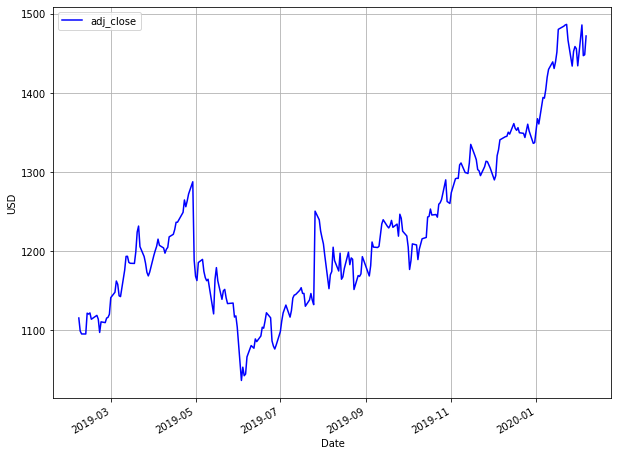

In [39]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = price_feature.plot(x='Date', y='adj_close', style='b-', grid=True)
ax.set_xlabel("Date")
ax.set_ylabel("USD")

# Feature Engineering

We will generate the following features:
* Mean 'adj_close' of each month
* Difference between high and low of each day
* Difference between open and close of each day
* Mean volume of each month

In [40]:
# Get difference between high and low of each day
price_feature['range_hl'] = price_feature['high'] - price_feature['low']
price_feature.drop(['high', 'low'], axis=1, inplace=True)

# Get difference between open and close of each day
price_feature['range_oc'] = price_feature['open'] - price_feature['close']
price_feature.drop(['open', 'close'], axis=1, inplace=True)

price_feature.head()

,Date,adj_close,volume,month,range_hl,range_oc
0,2019-02-06,1115.229980,2105600,2,34.229980,24.339966
1,2019-02-07,1098.709961,2044800,2,18.839966,5.450073
2,2019-02-08,1095.060059,1075800,2,12.359985,-8.060059
3,2019-02-11,1095.010010,1065200,2,13.084961,1.939941
4,2019-02-12,1121.369995,1609100,2,19.445068,-14.569946


Now we use lags up to N number of days to use as features.

In [41]:
# Add a column 'order_day' to indicate the order of the rows by date
price_feature['order_day'] = [x for x in list(range(len(price_feature)))]

# merging_keys
merging_keys = ['order_day']

# List of columns that we will use to create lags
lag_cols = ['adj_close', 'range_hl', 'range_oc', 'volume']
lag_cols

['adj_close', 'range_hl', 'range_oc', 'volume']

In [42]:
shift_range = [x + 1 for x in range(N)]

for shift in notebook.tqdm(shift_range):
    train_shift = price_feature[merging_keys + lag_cols].copy()
    
    # E.g. order_day of 0 becomes 1, for shift = 1.
    # So when this is merged with order_day of 1 in df, this will represent lag of 1.
    train_shift['order_day'] = train_shift['order_day'] + shift
    
    foo = lambda x: '{}_lag_{}'.format(x, shift) if x in lag_cols else x
    train_shift = train_shift.rename(columns=foo)

    price_feature = pd.merge(price_feature, train_shift, on=merging_keys, how='left') #.fillna(0)
    
del train_shift

# Remove the first N rows which contain NaNs
price_feature = price_feature[N:]
    
price_feature.head()

,Date,adj_close,volume,month,range_hl,range_oc,order_day,adj_close_lag_1,range_hl_lag_1,range_oc_lag_1,volume_lag_1,adj_close_lag_2,range_hl_lag_2,range_oc_lag_2,volume_lag_2
2,2019-02-08,1095.060059,1075800,2,12.359985,-8.060059,2,1098.709961,18.839966,5.450073,2044800.0,1115.229980,34.229980,24.339966,2105600.0
3,2019-02-11,1095.010010,1065200,2,13.084961,1.939941,3,1095.060059,12.359985,-8.060059,1075800.0,1098.709961,18.839966,5.450073,2044800.0
4,2019-02-12,1121.369995,1609100,2,19.445068,-14.569946,4,1095.010010,13.084961,1.939941,1065200.0,1095.060059,12.359985,-8.060059,1075800.0
5,2019-02-13,1120.160034,1049800,2,16.229980,4.829956,5,1121.369995,19.445068,-14.569946,1609100.0,1095.010010,13.084961,1.939941,1065200.0
6,2019-02-14,1121.670044,947600,2,17.785034,-3.619995,6,1120.160034,16.229980,4.829956,1049800.0,1121.369995,19.445068,-14.569946,1609100.0


In [43]:
price_feature.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 251 entries, 2 to 252
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Date             251 non-null    datetime64[ns]
 1   adj_close        251 non-null    float64       
 2   volume           251 non-null    int64         
 3   month            251 non-null    int64         
 4   range_hl         251 non-null    float64       
 5   range_oc         251 non-null    float64       
 6   order_day        251 non-null    int64         
 7   adj_close_lag_1  251 non-null    float64       
 8   range_hl_lag_1   251 non-null    float64       
 9   range_oc_lag_1   251 non-null    float64       
 10  volume_lag_1     251 non-null    float64       
 11  adj_close_lag_2  251 non-null    float64       
 12  range_hl_lag_2   251 non-null    float64       
 13  range_oc_lag_2   251 non-null    float64       
 14  volume_lag_2     251 non-null    float64  

In [44]:
# # Get mean of adj_close of each month
# df_gb = df.groupby(['month'], as_index=False).agg({'adj_close':'mean'})
# df_gb = df_gb.rename(columns={'adj_close':'adj_close_mean'})
# df_gb

# # Merge to main df
# df = df.merge(df_gb, 
#               left_on=['month'], 
#               right_on=['month'],
#               how='left').fillna(0)

# # Merge to main df
# shift_range = [x+1 for x in range(2)]

# for shift in tqdm_notebook(shift_range):
#     train_shift = df[merging_keys + lag_cols].copy()
    
#     # E.g. order_day of 0 becomes 1, for shift = 1.
#     # So when this is merged with order_day of 1 in df, this will represent lag of 1.
#     train_shift['order_day'] = train_shift['order_day'] + shift
    
#     foo = lambda x: '{}_lag_{}'.format(x, shift) if x in lag_cols else x
#     train_shift = train_shift.rename(columns=foo)

#     df = pd.merge(df, train_shift, on=merging_keys, how='left') #.fillna(0)
    
# del train_shift
    
# df

In [45]:
# # Get mean of volume of each month
# df_gb = df.groupby(['month'], as_index=False).agg({'volume':'mean'})
# df_gb = df_gb.rename(columns={'volume':'volume_mean'})
# df_gb

# # Merge to main df
# df = df.merge(df_gb, 
#               left_on=['month'], 
#               right_on=['month'],
#               how='left').fillna(0)

# df.head()

# Get mean and std dev at timestamp t using values from t-1, ..., t-N

In [46]:
cols_list = [
"adj_close",
"range_hl",
"range_oc",
"volume"
]

for col in cols_list:
    price_feature = get_mov_avg_std(price_feature, col, N)
price_feature.head()

,Date,adj_close,volume,month,range_hl,range_oc,order_day,adj_close_lag_1,range_hl_lag_1,range_oc_lag_1,...,range_oc_lag_2,volume_lag_2,adj_close_mean,adj_close_std,range_hl_mean,range_hl_std,range_oc_mean,range_oc_std,volume_mean,volume_std
2,2019-02-08,1095.060059,1075800,2,12.359985,-8.060059,2,1098.709961,18.839966,5.450073,...,24.339966,2105600.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2019-02-11,1095.010010,1065200,2,13.084961,1.939941,3,1095.060059,12.359985,-8.060059,...,5.450073,2044800.0,1095.060059,NaN,12.359985,NaN,-8.060059,NaN,1075800.0,NaN
4,2019-02-12,1121.369995,1609100,2,19.445068,-14.569946,4,1095.010010,13.084961,1.939941,...,-8.060059,1075800.0,1095.035034,0.035390,12.722473,0.512635,-3.060059,7.071068,1070500.0,7495.331881
5,2019-02-13,1120.160034,1049800,2,16.229980,4.829956,5,1121.369995,19.445068,-14.569946,...,1.939941,1065200.0,1108.190002,18.639324,16.265015,4.497275,-6.315002,11.674253,1337150.0,384595.378287
6,2019-02-14,1121.670044,947600,2,17.785034,-3.619995,6,1120.160034,16.229980,4.829956,...,-14.569946,1609100.0,1120.765015,0.855572,17.837524,2.273411,-4.869995,13.717802,1329450.0,395484.822718


In [47]:
price_feature.head()

,Date,adj_close,volume,month,range_hl,range_oc,order_day,adj_close_lag_1,range_hl_lag_1,range_oc_lag_1,...,range_oc_lag_2,volume_lag_2,adj_close_mean,adj_close_std,range_hl_mean,range_hl_std,range_oc_mean,range_oc_std,volume_mean,volume_std
2,2019-02-08,1095.060059,1075800,2,12.359985,-8.060059,2,1098.709961,18.839966,5.450073,...,24.339966,2105600.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2019-02-11,1095.010010,1065200,2,13.084961,1.939941,3,1095.060059,12.359985,-8.060059,...,5.450073,2044800.0,1095.060059,NaN,12.359985,NaN,-8.060059,NaN,1075800.0,NaN
4,2019-02-12,1121.369995,1609100,2,19.445068,-14.569946,4,1095.010010,13.084961,1.939941,...,-8.060059,1075800.0,1095.035034,0.035390,12.722473,0.512635,-3.060059,7.071068,1070500.0,7495.331881
5,2019-02-13,1120.160034,1049800,2,16.229980,4.829956,5,1121.369995,19.445068,-14.569946,...,1.939941,1065200.0,1108.190002,18.639324,16.265015,4.497275,-6.315002,11.674253,1337150.0,384595.378287
6,2019-02-14,1121.670044,947600,2,17.785034,-3.619995,6,1120.160034,16.229980,4.829956,...,-14.569946,1609100.0,1120.765015,0.855572,17.837524,2.273411,-4.869995,13.717802,1329450.0,395484.822718


# Split into train, dev and test set

In [48]:
# Get sizes of each of the datasets
num_cv = int(cv_size * (len(price_feature)))
num_test = int(test_size * len(price_feature))
num_train = len(price_feature) - num_cv - num_test
print("num_train = " + str(num_train))
print("num_cv = " + str(num_cv))
print("num_test = " + str(num_test))

# Split into train, cv, and test
train = price_feature[: num_train]
cv = price_feature[num_train: num_train + num_cv]
train_cv = price_feature[: num_train + num_cv]
test = price_feature[num_train + num_cv:]
print("train.shape = " + str(train.shape))
print("cv.shape = " + str(cv.shape))
print("train_cv.shape = " + str(train_cv.shape))
print("test.shape = " + str(test.shape))

num_train = 151
num_cv = 50
num_test = 50
train.shape = (151, 23)
cv.shape = (50, 23)
train_cv.shape = (201, 23)
test.shape = (50, 23)


# Scale the train, dev and test set

In [49]:
def timestamp_to_pydate(stamp):
    return stamp.to_pydatetime().date()

In [50]:
cols_to_scale = [
    "adj_close"
]

for i in range(1, N + 1):
    cols_to_scale.append("adj_close_lag_" + str(i))
    cols_to_scale.append("range_hl_lag_" + str(i))
    cols_to_scale.append("range_oc_lag_" + str(i))
    cols_to_scale.append("volume_lag_" + str(i))

# Do scaling for train set
# Here we only scale the train dataset, and not the entire dataset to prevent information leak
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train[cols_to_scale])
print("scaler.mean_ = " + str(scaler.mean_))
print("scaler.var_ = " + str(scaler.var_))
print("train_scaled.shape = " + str(train_scaled.shape))

# Convert the numpy array back into pandas dataframe
train_scaled = pd.DataFrame(train_scaled, columns=cols_to_scale)
train_scaled[['Date', 'month']] = train.reset_index()[['Date', 'month']]
# re-order columns
train_scaled = train_scaled[['Date', 'month'] + cols_to_scale]
print("train_scaled.shape = " + str(train_scaled.shape))

train_scaled.Date = train_scaled.Date.apply(lambda x: timestamp_to_pydate(x))

train_scaled.head()

scaler.mean_ = [ 1.16034146e+03  1.15940868e+03  1.83235211e+01 -1.17208446e+00
  1.44896424e+06  1.15862046e+03  1.84254417e+01 -9.44998921e-01
  1.45147881e+06]
scaler.var_ = [2.57707360e+03 2.55979859e+03 5.55520081e+01 1.33891147e+02
 4.84639483e+11 2.53500866e+03 5.72154528e+01 1.37639670e+02
 4.86980690e+11]
train_scaled.shape = (151, 9)
train_scaled.shape = (151, 11)


,Date,month,adj_close,adj_close_lag_1,range_hl_lag_1,range_oc_lag_1,volume_lag_1,adj_close_lag_2,range_hl_lag_2,range_oc_lag_2,volume_lag_2
0,2019-02-08,2,-1.285956,-1.199711,0.069291,0.572300,0.855888,-0.861797,2.089417,2.155215,0.937351
1,2019-02-11,2,-1.286942,-1.271851,-0.800118,-0.595272,-0.536032,-1.189908,0.054802,0.545097,0.850225
2,2019-02-12,2,-0.767685,-1.272840,-0.702849,0.268947,-0.551258,-1.262400,-0.801875,-0.606466,-0.538345
3,2019-02-13,2,-0.791520,-0.751835,0.150476,-1.157869,0.230027,-1.263394,-0.706031,0.245904,-0.553535
4,2019-02-14,2,-0.761775,-0.775750,-0.280887,0.518708,-0.573380,-0.739847,0.134798,-1.161350,0.225870


In [51]:
# Do scaling for train+dev set
scaler_train_cv = StandardScaler()
train_cv_scaled = scaler_train_cv.fit_transform(train_cv[cols_to_scale])
print("scaler_train_cv.mean_ = " + str(scaler_train_cv.mean_))
print("scaler_train_cv.var_ = " + str(scaler_train_cv.var_))
print("train_cv_scaled.shape = " + str(train_cv_scaled.shape))

# Convert the numpy array back into pandas dataframe
train_cv_scaled = pd.DataFrame(train_cv_scaled, columns=cols_to_scale)
train_cv_scaled[['Date', 'month']] = train_cv.reset_index()[['Date', 'month']]
train_cv_scaled = train_cv_scaled[['Date', 'month'] + cols_to_scale]
print("train_cv_scaled.shape = " + str(train_cv_scaled.shape))

train_cv_scaled.Date = train_cv_scaled.Date.apply(lambda x: timestamp_to_pydate(x))

train_cv_scaled.head()

scaler_train_cv.mean_ = [ 1.18386871e+03  1.18289045e+03  1.82636391e+01 -1.37669327e+00
  1.41048060e+06  1.18196448e+03  1.83364750e+01 -1.25624570e+00
  1.41600348e+06]
scaler_train_cv.var_ = [3.99828459e+03 3.97158716e+03 5.30965433e+01 1.30304904e+02
 4.01734278e+11 3.92369133e+03 5.43507651e+01 1.33569384e+02
 4.03250950e+11]
train_cv_scaled.shape = (201, 9)
train_cv_scaled.shape = (201, 11)


,Date,month,adj_close,adj_close_lag_1,range_hl_lag_1,range_oc_lag_1,volume_lag_1,adj_close_lag_2,range_hl_lag_2,range_oc_lag_2,volume_lag_2
0,2019-02-08,2,-1.404489,-1.335763,0.079093,0.598046,1.000780,-1.065376,2.155842,2.214737,1.085944
1,2019-02-11,2,-1.405281,-1.393679,-0.810192,-0.585484,-0.528033,-1.329108,0.068295,0.580271,0.990199
2,2019-02-12,2,-0.988403,-1.394473,-0.710699,0.290548,-0.544757,-1.387377,-0.810669,-0.588707,-0.535736
3,2019-02-13,2,-1.007539,-0.976197,0.162134,-1.155770,0.313366,-1.388176,-0.712331,0.276553,-0.552429
4,2019-02-14,2,-0.983658,-0.995397,-0.279090,0.543722,-0.569054,-0.967355,0.150373,-1.151981,0.304079


In [52]:
# Do scaling for dev set
cv_scaled = cv[['Date']]
for col in notebook.tqdm(cols_list):
    feat_list = [col + '_lag_' + str(shift) for shift in range(1, N + 1)]
    temp = cv.apply(lambda row: scale_row(row[feat_list], row[col + '_mean'], row[col + '_std']), axis=1)
    cv_scaled = pd.concat([cv_scaled, temp], axis=1)
    
# Now the entire dev set is scaled

cv_scaled.Date = cv_scaled.Date.apply(lambda x: timestamp_to_pydate(x))

cv_scaled.head()

,Date,adj_close_lag_1,adj_close_lag_2,range_hl_lag_1,range_hl_lag_2,range_oc_lag_1,range_oc_lag_2,volume_lag_1,volume_lag_2
153,2019-09-16,0.707107,-0.707107,-0.707107,0.707107,0.707107,-0.707107,-0.707107,0.707107
154,2019-09-17,-0.707107,0.707107,0.707107,-0.707107,0.707107,-0.707107,-0.707107,0.707107
155,2019-09-18,-0.707107,0.707107,-0.707107,0.707107,0.707107,-0.707107,-0.707107,0.707107
156,2019-09-19,0.707107,-0.707107,0.707107,-0.707107,-0.707107,0.707107,0.707107,-0.707107
157,2019-09-20,0.707107,-0.707107,-0.707107,0.707107,-0.707107,0.707107,-0.707107,0.707107


In [53]:
# Do scaling for test set
test_scaled = test[['Date']]
for col in notebook.tqdm(cols_list):
    feat_list = [col + '_lag_' + str(shift) for shift in range(1, N + 1)]
    temp = test.apply(lambda row: scale_row(row[feat_list], row[col + '_mean'], row[col + '_std']), axis=1)
    test_scaled = pd.concat([test_scaled, temp], axis=1)
    
# Now the entire test set is scaled
test_scaled.Date = test_scaled.Date.apply(lambda x: timestamp_to_pydate(x))

test_scaled.head()

,Date,adj_close_lag_1,adj_close_lag_2,range_hl_lag_1,range_hl_lag_2,range_oc_lag_1,range_oc_lag_2,volume_lag_1,volume_lag_2
203,2019-11-25,-0.707107,0.707107,-0.707107,0.707107,0.707107,-0.707107,0.707107,-0.707107
204,2019-11-26,0.707107,-0.707107,-0.707107,0.707107,-0.707107,0.707107,-0.707107,0.707107
205,2019-11-27,0.707107,-0.707107,-0.707107,0.707107,0.707107,-0.707107,0.707107,-0.707107
206,2019-11-29,-0.707107,0.707107,-0.707107,0.707107,0.707107,-0.707107,-0.707107,0.707107
207,2019-12-02,-0.707107,0.707107,-0.707107,0.707107,0.707107,-0.707107,-0.707107,0.707107


- append BERT, hand-crafted features to price features

In [54]:
def string_to_datetime(string):
    date_parts = [int(part) for part in string.split('-')]
    return datetime.date(date_parts[0], date_parts[1], date_parts[2])

twitter_feature = pd.read_csv('final_feature_from_twitter.csv')
twitter_feature = twitter_feature.drop(['Label', 'Adj Close'], axis=1)
twitter_feature.Date = twitter_feature.Date.apply(lambda x: string_to_datetime(x))

twitter_feature.head()

,Date,0_lag1,1_lag1,2_lag1,3_lag1,4_lag1,5_lag1,6_lag1,7_lag1,8_lag1,...,num_pos_VB_lag2,num_pos_NN_lag2,num_neg_JJ_lag2,num_neg_RB_lag2,num_neg_VB_lag2,num_neg_NN_lag2,total_score_JJ_lag2,total_score_RB_lag2,total_score_VB_lag2,total_score_NN_lag2
0,2019-02-08,-1.954738,-14.441650,63.646112,-10.731836,39.554150,-40.863590,-10.272327,47.880675,-21.620840,...,3.998121,55.419917,53.802890,42.127785,0.0,59.779481,23.410036,4.487775,1.999061,9.431500
1,2019-02-11,5.805648,-10.267495,53.630592,0.306161,39.197539,-29.663042,-12.035486,48.976293,-21.195179,...,2.000000,18.000000,37.000000,8.000000,2.0,12.000000,5.026641,2.214286,0.675000,6.566667
2,2019-02-12,12.109340,-1.015043,59.919780,-12.517981,36.486913,-34.995952,-12.471680,36.736582,-16.731461,...,3.000000,24.000000,16.000000,1.000000,1.0,12.000000,8.259351,2.350000,0.900000,9.300000
3,2019-02-13,6.390824,-82.130350,211.913261,20.252170,122.859405,-164.221742,-45.784676,166.307355,-66.180203,...,2.000000,22.000000,20.000000,4.000000,0.0,10.000000,9.891429,2.069444,1.600000,8.600000
4,2019-02-14,0.176889,-9.644508,68.011613,-8.693843,35.417869,-39.694949,-15.748714,35.073030,-13.761981,...,3.419543,45.266850,134.814683,4.000000,1.0,12.000000,16.288132,10.861708,1.267817,18.083712


In [55]:
twitter_feature.iloc[0][0]

datetime.date(2019, 2, 8)

In [56]:
train_scaled.iloc[0][0]

datetime.date(2019, 2, 8)

In [57]:
train_feature_with_price_and_twitter = pd.merge(left=train_scaled, right=twitter_feature, how='inner', on='Date', sort=False)
train_cv_feature_with_price_and_twitter = pd.merge(left=train_cv_scaled, right=twitter_feature, how='inner', on='Date', sort=False)
cv_feature_with_price_and_twitter = pd.merge(left=cv_scaled, right=twitter_feature, how='inner', on='Date', sort=False)
test_feature_with_price_and_twitter = pd.merge(left=test_scaled, right=twitter_feature, how='inner', on='Date', sort=False)

In [58]:
train_feature_with_price_and_twitter.head()

,Date,month,adj_close,adj_close_lag_1,range_hl_lag_1,range_oc_lag_1,volume_lag_1,adj_close_lag_2,range_hl_lag_2,range_oc_lag_2,...,num_pos_VB_lag2,num_pos_NN_lag2,num_neg_JJ_lag2,num_neg_RB_lag2,num_neg_VB_lag2,num_neg_NN_lag2,total_score_JJ_lag2,total_score_RB_lag2,total_score_VB_lag2,total_score_NN_lag2
0,2019-02-08,2,-1.285956,-1.199711,0.069291,0.572300,0.855888,-0.861797,2.089417,2.155215,...,3.998121,55.419917,53.802890,42.127785,0.0,59.779481,23.410036,4.487775,1.999061,9.431500
1,2019-02-11,2,-1.286942,-1.271851,-0.800118,-0.595272,-0.536032,-1.189908,0.054802,0.545097,...,2.000000,18.000000,37.000000,8.000000,2.0,12.000000,5.026641,2.214286,0.675000,6.566667
2,2019-02-12,2,-0.767685,-1.272840,-0.702849,0.268947,-0.551258,-1.262400,-0.801875,-0.606466,...,3.000000,24.000000,16.000000,1.000000,1.0,12.000000,8.259351,2.350000,0.900000,9.300000
3,2019-02-13,2,-0.791520,-0.751835,0.150476,-1.157869,0.230027,-1.263394,-0.706031,0.245904,...,2.000000,22.000000,20.000000,4.000000,0.0,10.000000,9.891429,2.069444,1.600000,8.600000
4,2019-02-14,2,-0.761775,-0.775750,-0.280887,0.518708,-0.573380,-0.739847,0.134798,-1.161350,...,3.419543,45.266850,134.814683,4.000000,1.0,12.000000,16.288132,10.861708,1.267817,18.083712


In [59]:
train_cv_feature_with_price_and_twitter.head()

,Date,month,adj_close,adj_close_lag_1,range_hl_lag_1,range_oc_lag_1,volume_lag_1,adj_close_lag_2,range_hl_lag_2,range_oc_lag_2,...,num_pos_VB_lag2,num_pos_NN_lag2,num_neg_JJ_lag2,num_neg_RB_lag2,num_neg_VB_lag2,num_neg_NN_lag2,total_score_JJ_lag2,total_score_RB_lag2,total_score_VB_lag2,total_score_NN_lag2
0,2019-02-08,2,-1.404489,-1.335763,0.079093,0.598046,1.000780,-1.065376,2.155842,2.214737,...,3.998121,55.419917,53.802890,42.127785,0.0,59.779481,23.410036,4.487775,1.999061,9.431500
1,2019-02-11,2,-1.405281,-1.393679,-0.810192,-0.585484,-0.528033,-1.329108,0.068295,0.580271,...,2.000000,18.000000,37.000000,8.000000,2.0,12.000000,5.026641,2.214286,0.675000,6.566667
2,2019-02-12,2,-0.988403,-1.394473,-0.710699,0.290548,-0.544757,-1.387377,-0.810669,-0.588707,...,3.000000,24.000000,16.000000,1.000000,1.0,12.000000,8.259351,2.350000,0.900000,9.300000
3,2019-02-13,2,-1.007539,-0.976197,0.162134,-1.155770,0.313366,-1.388176,-0.712331,0.276553,...,2.000000,22.000000,20.000000,4.000000,0.0,10.000000,9.891429,2.069444,1.600000,8.600000
4,2019-02-14,2,-0.983658,-0.995397,-0.279090,0.543722,-0.569054,-0.967355,0.150373,-1.151981,...,3.419543,45.266850,134.814683,4.000000,1.0,12.000000,16.288132,10.861708,1.267817,18.083712


In [60]:
cv_feature_with_price_and_twitter.head()

,Date,adj_close_lag_1,adj_close_lag_2,range_hl_lag_1,range_hl_lag_2,range_oc_lag_1,range_oc_lag_2,volume_lag_1,volume_lag_2,0_lag1,...,num_pos_VB_lag2,num_pos_NN_lag2,num_neg_JJ_lag2,num_neg_RB_lag2,num_neg_VB_lag2,num_neg_NN_lag2,total_score_JJ_lag2,total_score_RB_lag2,total_score_VB_lag2,total_score_NN_lag2
0,2019-09-16,0.707107,-0.707107,-0.707107,0.707107,0.707107,-0.707107,-0.707107,0.707107,8.015431,...,0.0,30.000000,12.0,1.0,0.0,17.0,10.136515,1.375000,0.0,8.814286
1,2019-09-17,-0.707107,0.707107,0.707107,-0.707107,0.707107,-0.707107,-0.707107,0.707107,13.706074,...,0.0,27.000000,8.0,2.0,0.0,13.0,7.183929,0.500000,0.0,11.483333
2,2019-09-18,-0.707107,0.707107,-0.707107,0.707107,0.707107,-0.707107,-0.707107,0.707107,4.292970,...,1.0,35.103337,5.0,3.0,0.0,13.0,21.241205,0.338889,0.1,14.308296
3,2019-09-19,0.707107,-0.707107,0.707107,-0.707107,-0.707107,0.707107,0.707107,-0.707107,3.814739,...,0.0,27.000000,6.0,3.0,0.0,15.0,8.013030,-0.072222,0.0,11.866667
4,2019-09-20,0.707107,-0.707107,-0.707107,0.707107,-0.707107,0.707107,-0.707107,0.707107,9.038561,...,0.0,29.000000,6.0,3.0,0.0,15.0,7.418669,1.638889,0.0,11.977381


In [61]:
test_feature_with_price_and_twitter.head()

,Date,adj_close_lag_1,adj_close_lag_2,range_hl_lag_1,range_hl_lag_2,range_oc_lag_1,range_oc_lag_2,volume_lag_1,volume_lag_2,0_lag1,...,num_pos_VB_lag2,num_pos_NN_lag2,num_neg_JJ_lag2,num_neg_RB_lag2,num_neg_VB_lag2,num_neg_NN_lag2,total_score_JJ_lag2,total_score_RB_lag2,total_score_VB_lag2,total_score_NN_lag2
0,2019-11-25,-0.707107,0.707107,-0.707107,0.707107,0.707107,-0.707107,0.707107,-0.707107,10.068995,...,2.0,23.000000,15.000000,5.0,1.0,13.0,2.535808,1.790476,1.375000,9.114286
1,2019-11-26,0.707107,-0.707107,-0.707107,0.707107,-0.707107,0.707107,-0.707107,0.707107,5.379677,...,1.0,26.825376,8.000000,0.0,0.0,13.0,42.680469,4.332802,0.136364,10.834766
2,2019-11-27,0.707107,-0.707107,-0.707107,0.707107,0.707107,-0.707107,0.707107,-0.707107,5.660011,...,2.0,23.000000,15.000000,1.0,0.0,18.0,4.421104,0.366667,1.000000,6.200000
3,2019-11-29,-0.707107,0.707107,-0.707107,0.707107,0.707107,-0.707107,-0.707107,0.707107,-0.089607,...,2.0,26.000000,15.000000,3.0,1.0,14.0,3.058810,0.666667,0.450000,9.700000
4,2019-12-02,-0.707107,0.707107,-0.707107,0.707107,0.707107,-0.707107,-0.707107,0.707107,4.908326,...,2.0,26.438785,23.871174,3.0,1.0,14.0,29.343074,1.884888,0.800000,10.769393


# Split into X and y (unscaled)

In [62]:
price_feature_list = test.columns.drop(['Date', 'adj_close']).to_list()
# price_feature_list = price_feature_list.remove('Date')
# price_feature_list = price_feature_list.remove('adj_close')

features = price_feature_list.copy()
target = "adj_close"

# Split into X and y
X_train = train[features]
y_train = train[target]
X_cv = cv[features]
y_cv = cv[target]
X_train_cv = train_cv[features]
y_train_cv = train_cv[target]
X_sample = test[features]
y_sample = test[target]
print("X_train.shape = " + str(X_train.shape))
print("y_train.shape = " + str(y_train.shape))
print("X_cv.shape = " + str(X_cv.shape))
print("y_cv.shape = " + str(y_cv.shape))
print("X_train_cv.shape = " + str(X_train_cv.shape))
print("y_train_cv.shape = " + str(y_train_cv.shape))
print("X_sample.shape = " + str(X_sample.shape))
print("y_sample.shape = " + str(y_sample.shape))

X_train.shape = (151, 21)
y_train.shape = (151,)
X_cv.shape = (50, 21)
y_cv.shape = (50,)
X_train_cv.shape = (201, 21)
y_train_cv.shape = (201,)
X_sample.shape = (50, 21)
y_sample.shape = (50,)


# Split into X and y (scaled)

In [63]:
price_and_twitter_feature_list = test_feature_with_price_and_twitter.columns.drop(['Date']).to_list()
# feature_list

In [64]:
features = price_and_twitter_feature_list.copy()

target = "adj_close"

# Split into X and y
X_train_scaled = train_feature_with_price_and_twitter[features]
y_train_scaled = train_feature_with_price_and_twitter[target]
X_cv_scaled = cv_feature_with_price_and_twitter[features]
X_train_cv_scaled = train_cv_feature_with_price_and_twitter[features]
y_train_cv_scaled = train_cv_feature_with_price_and_twitter[target]
X_sample_scaled = test_feature_with_price_and_twitter[features]
print("X_train_scaled.shape = " + str(X_train_scaled.shape))
print("y_train_scaled.shape = " + str(y_train_scaled.shape))
print("X_cv_scaled.shape = " + str(X_cv_scaled.shape))
print("X_train_cv_scaled.shape = " + str(X_train_cv_scaled.shape))
print("y_train_cv_scaled.shape = " + str(y_train_cv_scaled.shape))
print("X_sample_scaled.shape = " + str(X_sample_scaled.shape))

X_train_scaled.shape = (151, 1608)
y_train_scaled.shape = (151,)
X_cv_scaled.shape = (50, 1608)
X_train_cv_scaled.shape = (201, 1608)
y_train_cv_scaled.shape = (201,)
X_sample_scaled.shape = (50, 1608)


# EDA

Text(0.5, 1.0, 'Without scaling')

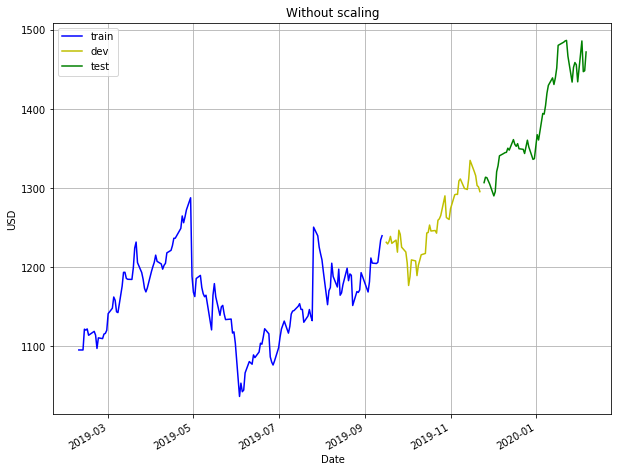

In [65]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = train.plot(x='Date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='Date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='Date', y='adj_close', style='g-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test'])
ax.set_xlabel("Date")
ax.set_ylabel("USD")
ax.set_title("Without scaling")

Text(0.5, 1.0, 'With scaling')

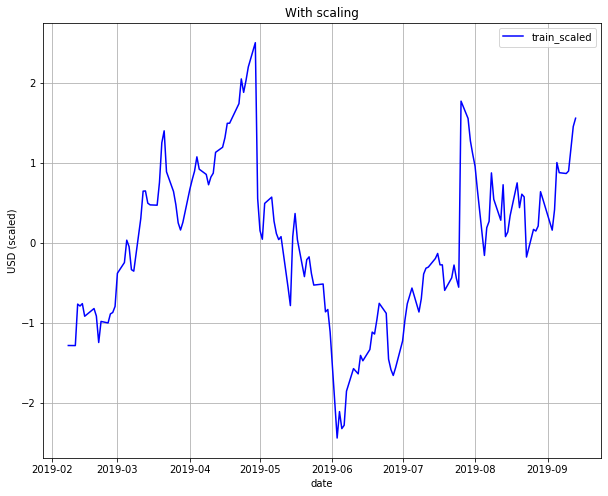

In [66]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = train_scaled.plot(x='Date', y='adj_close', style='b-', grid=True)
ax.legend(['train_scaled'])
ax.set_xlabel("date")
ax.set_ylabel("USD (scaled)")
ax.set_title("With scaling")

# Train the model using XGBoost

In [67]:
# Create the model
model = XGBRegressor(seed=model_seed,
                     n_estimators=n_estimators,
                     max_depth=max_depth,
                     learning_rate=learning_rate,
                     min_child_weight=min_child_weight,
                     subsample=subsample,
                     colsample_bytree=colsample_bytree,
                     colsample_bylevel=colsample_bylevel,
                     gamma=gamma)

# Train the regressor
model.fit(X_train_scaled, y_train_scaled)

[21:18:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=100,
             silent=None, subsample=1, verbosity=1)

# Predict on train set

In [43]:
# Do prediction on train set
est_scaled = model.predict(X_train_scaled)

# recover back to unscaled
est = est_scaled * math.sqrt(scaler.var_[0]) + scaler.mean_[0]

# Calculate RMSE
print("RMSE on train set = %0.3f" % math.sqrt(mean_squared_error(y_train, est))) 

# Calculate MAPE
print("MAPE on train set = %0.3f%%" % get_mape(y_train, est))

RMSE on train set = 13.473
MAPE on train set = 0.843%


Text(0.5, 1.0, 'Without scaling')

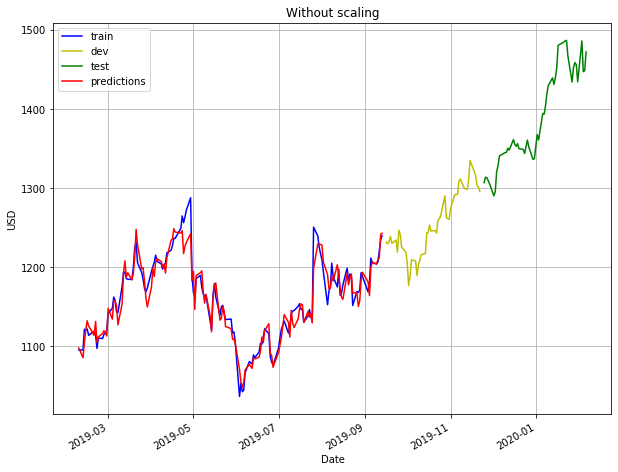

In [35]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

est_df = pd.DataFrame({'est': est, 
                       'Date': train['Date']})

ax = train.plot(x='Date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='Date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='Date', y='adj_close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='Date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("Date")
ax.set_ylabel("USD")
ax.set_title('Without scaling')

# Predict on valid set

In [41]:
# Do prediction on valid set
est_scaled = model.predict(X_cv_scaled)
cv['est_scaled'] = est_scaled
cv['est'] = cv['est_scaled'] * cv['adj_close_std'] + cv['adj_close_mean']

# Calculate RMSE
rmse_bef_tuning = math.sqrt(mean_squared_error(y_cv, cv['est']))
print("RMSE on valid set = %0.3f" % rmse_bef_tuning)

# Calculate MAPE
mape_bef_tuning = get_mape(y_cv, cv['est'])
print("MAPE on valid set = %0.3f%%" % mape_bef_tuning)

RMSE on valid set = 12.227
MAPE on valid set = 0.767%


/Users/frostace/.conda/envs/bert_env/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/frostace/.conda/envs/bert_env/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Text(0, 0.5, 'USD')

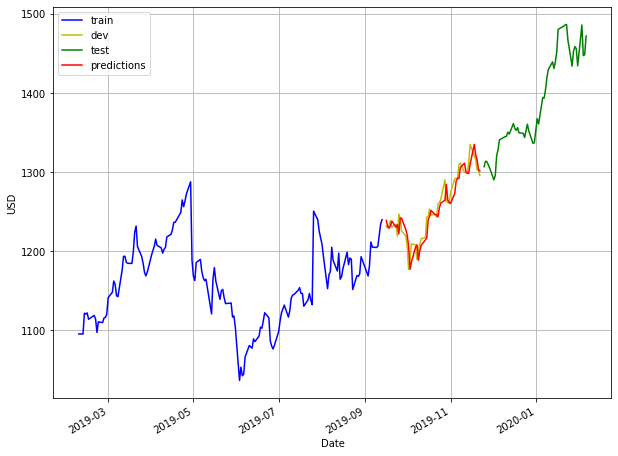

In [36]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

est_df = pd.DataFrame({'est': cv['est'], 
                       'y_cv': y_cv,
                       'Date': cv['Date']})

ax = train.plot(x='Date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='Date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='Date', y='adj_close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='Date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("Date")
ax.set_ylabel("USD")

Text(0.5, 1.0, 'Performance on valid set')

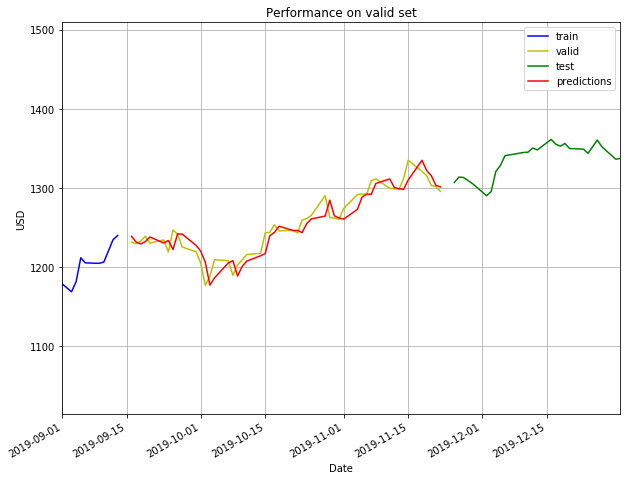

In [37]:
# Plot adjusted close over time, for dev set only
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
ax = train.plot(x='Date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='Date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='Date', y='adj_close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='Date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'valid', 'test', 'predictions'])
ax.set_xlabel("Date")
ax.set_ylabel("USD")
ax.set_xlim([date(2019, 9, 1), date(2019, 12, 31)])
ax.set_title("Performance on valid set")

The predictions capture the turn in directions with a slight lag

In [38]:
# View a list of the features and their importance scores
imp = list(zip(X_train_scaled[features], model.feature_importances_))
imp.sort(key=lambda tup: tup[1]) 
imp[-10:]

[('total_score_JJ_lag1', 0.02232025),
 ('121_lag1', 0.022938881),
 ('206_lag1', 0.027626662),
 ('470_lag1', 0.027964506),
 ('22_lag1', 0.03074996),
 ('158_lag1', 0.031193817),
 ('692_lag1', 0.035224386),
 ('1_lag1', 0.04035098),
 ('87_lag1', 0.053325057),
 ('adj_close_lag_1', 0.12957473)]

Importance features dominated by adj_close and volume

# Tuning N (no. of days to use as features)

In [39]:
d = {'N': [2, 3, 4, 5, 6, 7, 14],
     'rmse_dev_set': [1.225, 1.214, 1.231, 1.249, 1.254, 1.251, 1.498],
     'mape_pct_dev_set': [0.585, 0.581, 0.590, 0.601, 0.609, 0.612, 0.763]}
pd.DataFrame(d)

,N,rmse_dev_set,mape_pct_dev_set
0,2,1.225,0.585
1,3,1.214,0.581
2,4,1.231,0.590
3,5,1.249,0.601
4,6,1.254,0.609
5,7,1.251,0.612
6,14,1.498,0.763


Use N = 3 for lowest RMSE and MAPE

# Tuning XGBoost - n_estimators (default=100) and max_depth (default=3)

In [40]:
param_label = 'n_estimators'
param_list = range(10, 310, 10)

param2_label = 'max_depth'
param2_list = [2, 3, 4, 5, 6, 7, 8, 9]

error_rate = {param_label: [] , param2_label: [], 'rmse': [], 'mape_pct': []}
tic = time.time()
for param in notebook.tqdm(param_list):
#     print("param = " + str(param))
    
    for param2 in param2_list:
        # Train, predict and eval model
        rmse, mape, _ = train_pred_eval_model(X_train_scaled, 
                                     y_train_scaled, 
                                     X_cv_scaled, 
                                     y_cv, 
                                     cv['adj_close_mean'],
                                     cv['adj_close_std'],
                                     seed=model_seed,
                                     n_estimators=param, 
                                     max_depth=param2, 
                                     learning_rate=learning_rate, 
                                     min_child_weight=min_child_weight, 
                                     subsample=subsample, 
                                     colsample_bytree=colsample_bytree, 
                                     colsample_bylevel=colsample_bylevel, 
                                     gamma=gamma)
    
        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse)
        error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))
error_rate   

[12:00:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:00:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:00:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:00:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:00:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:00:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:00:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:00:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:00:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

KeyboardInterrupt: 

In [ ]:
# Plot performance versus params
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

In [ ]:
# Get optimum value for param and param2
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
n_estimators_opt = temp['n_estimators'].values[0]
max_depth_opt = temp['max_depth'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = ")
n_estimators_opt, max_depth_opt

In [ ]:
# Get optimum value for param and param2, using MAPE
temp = error_rate[error_rate['mape_pct'] == error_rate['mape_pct'].min()]
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum params = ")
temp['n_estimators'].values[0], temp['max_depth'].values[0]

# Tuning XGBoost - learning_rate(default=0.1) and min_child_weight(default=1)

In [ ]:
param_label = 'learning_rate'
param_list = [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3]

param2_label = 'min_child_weight'
param2_list = range(5, 21, 1)

error_rate = {param_label: [] , param2_label: [], 'rmse': [], 'mape_pct': []}
tic = time.time()
for param in notebook.tqdm(param_list):
#     print("param = " + str(param))
    
    for param2 in param2_list:
        # Train, predict and eval model
        rmse, mape, _ = train_pred_eval_model(X_train_scaled, 
                                     y_train_scaled, 
                                     X_cv_scaled, 
                                     y_cv, 
                                     cv['adj_close_mean'],
                                     cv['adj_close_std'],
                                     seed=model_seed,
                                     n_estimators=n_estimators_opt, 
                                     max_depth=max_depth_opt, 
                                     learning_rate=param, 
                                     min_child_weight=param2, 
                                     subsample=subsample, 
                                     colsample_bytree=colsample_bytree, 
                                     colsample_bylevel=colsample_bylevel, 
                                     gamma=gamma)
    
        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse)
        error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))
error_rate   

In [ ]:
# Plot performance versus params
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

In [ ]:
# Get optimum value for param and param2
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
learning_rate_opt = temp['learning_rate'].values[0]
min_child_weight_opt = temp['min_child_weight'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = ")
learning_rate_opt, min_child_weight_opt

In [ ]:
# Get optimum value for param and param2, using MAPE
# We will use RMSE to decide the final optimum params to use
temp = error_rate[error_rate['mape_pct'] == error_rate['mape_pct'].min()]
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum params = ")
temp['learning_rate'].values[0], temp['min_child_weight'].values[0]

# Tuning XGBoost - subsample(default=1) and gamma(default=0)

In [ ]:
param_label = 'subsample'
param_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

param2_label = 'gamma'
param2_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

error_rate = {param_label: [] , param2_label: [], 'rmse': [], 'mape_pct': []}
tic = time.time()
for param in notebook.tqdm(param_list):
#     print("param = " + str(param))
    
    for param2 in param2_list:
        # Train, predict and eval model
        rmse, mape, _ = train_pred_eval_model(X_train_scaled, 
                                     y_train_scaled, 
                                     X_cv_scaled, 
                                     y_cv, 
                                     cv['adj_close_mean'],
                                     cv['adj_close_std'],
                                     seed=model_seed,
                                     n_estimators=n_estimators_opt, 
                                     max_depth=max_depth_opt, 
                                     learning_rate=learning_rate_opt, 
                                     min_child_weight=min_child_weight_opt, 
                                     subsample=param, 
                                     colsample_bytree=colsample_bytree, 
                                     colsample_bylevel=colsample_bylevel, 
                                     gamma=param2)
    
        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse)
        error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))
error_rate   

In [ ]:
# Plot performance versus params
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

In [ ]:
# Get optimum value for param and param2
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
subsample_opt = temp['subsample'].values[0]
gamma_opt = temp['gamma'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = ")
subsample_opt, gamma_opt

In [ ]:
# Get optimum value for param and param2, using MAPE
# We will use RMSE to decide the final optimum params to use
temp = error_rate[error_rate['mape_pct'] == error_rate['mape_pct'].min()]
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum params = ")
temp['subsample'].values[0], temp['gamma'].values[0]

# Tuning XGBoost - colsample_bytree(default=1) and colsample_bylevel(default=1)

In [ ]:
param_label = 'colsample_bytree'
param_list = [0.5, 0.6, 0.7, 0.8, 0.9, 1]

param2_label = 'colsample_bylevel'
param2_list = [0.5, 0.6, 0.7, 0.8, 0.9, 1]

error_rate = {param_label: [] , param2_label: [], 'rmse': [], 'mape_pct': []}
tic = time.time()
for param in notebook.tqdm(param_list):
#     print("param = " + str(param))
    
    for param2 in param2_list:
        # Train, predict and eval model
        rmse, mape, _ = train_pred_eval_model(X_train_scaled, 
                                     y_train_scaled, 
                                     X_cv_scaled, 
                                     y_cv, 
                                     cv['adj_close_mean'],
                                     cv['adj_close_std'],
                                     seed=model_seed,
                                     n_estimators=n_estimators_opt, 
                                     max_depth=max_depth_opt, 
                                     learning_rate=learning_rate_opt, 
                                     min_child_weight=min_child_weight_opt, 
                                     subsample=subsample_opt, 
                                     colsample_bytree=param, 
                                     colsample_bylevel=param2, 
                                     gamma=gamma_opt)
    
        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse)
        error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))
error_rate   

In [ ]:
# Plot performance versus params
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

In [ ]:
# Get optimum value for param and param2
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
colsample_bytree_opt = temp['colsample_bytree'].values[0]
colsample_bylevel_opt = temp['colsample_bylevel'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = ")
colsample_bytree_opt, colsample_bylevel_opt

In [ ]:
# Get optimum value for param and param2, using MAPE
# We will use RMSE to decide the final optimum params to use
temp = error_rate[error_rate['mape_pct'] == error_rate['mape_pct'].min()]
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum params = ")
temp['colsample_bytree'].values[0], temp['colsample_bylevel'].values[0]

# Tuned params

In [ ]:
d = {'param': ['n_estimators', 'max_depth', 'learning_rate', 'min_child_weight', 'subsample', 'colsample_bytree', 'colsample_bylevel', 'gamma', 'rmse', 'mape_pct'],
     'original': [n_estimators, max_depth, learning_rate, min_child_weight, subsample, colsample_bytree, colsample_bylevel, gamma, rmse_bef_tuning, mape_bef_tuning],
     'after_tuning': [n_estimators_opt, max_depth_opt, learning_rate_opt, min_child_weight_opt, subsample_opt, colsample_bytree_opt, colsample_bylevel_opt, gamma_opt, error_rate['rmse'].min(), error_rate['mape_pct'].min()]}
tuned_params = pd.DataFrame(d)
tuned_params = tuned_params.round(3)
tuned_params

# Final model

In [ ]:
# rmse, mape, est = train_pred_eval_model(X_train_cv_scaled, 
#                              y_train_cv_scaled, 
#                              X_sample_scaled, 
#                              y_sample, 
#                              test['adj_close_mean'],
#                              test['adj_close_std'],
#                              seed=model_seed,
#                              n_estimators=n_estimators_opt, 
#                              max_depth=max_depth_opt, 
#                              learning_rate=learning_rate_opt, 
#                              min_child_weight=min_child_weight_opt, 
#                              subsample=subsample_opt, 
#                              colsample_bytree=colsample_bytree_opt, 
#                              colsample_bylevel=colsample_bylevel_opt, 
#                              gamma=gamma_opt)

# # Calculate RMSE
# print("RMSE on test set = %0.3f" % rmse)

# # Calculate MAPE
# print("MAPE on test set = %0.3f%%" % mape)

In [68]:
# hardcode hyperparams for training since we already have the hyperparams
rmse, mape, est = train_pred_eval_model(X_train_cv_scaled, 
                             y_train_cv_scaled, 
                             X_sample_scaled, 
                             y_sample, 
                             test['adj_close_mean'],
                             test['adj_close_std'],
                             seed=100,
                             n_estimators=270, 
                             max_depth=3, 
                             learning_rate=0.3, 
                             min_child_weight=13, 
                             subsample=0.4, 
                             colsample_bytree=1, 
                             colsample_bylevel=1, 
                             gamma=0.1)


# Calculate RMSE
print("RMSE on test set = %0.3f" % rmse)

# Calculate MAPE
print("MAPE on test set = %0.3f%%" % mape)

[21:19:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSE on test set = 15.726
MAPE on test set = 0.813%


Text(0, 0.5, 'USD')

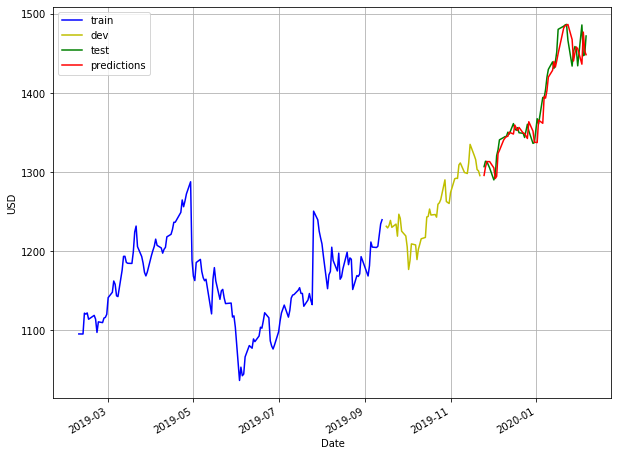

In [69]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

est_df = pd.DataFrame({'est': est, 
                       'y_sample': y_sample,
                       'Date': test['Date']})

ax = train.plot(x='Date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='Date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='Date', y='adj_close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='Date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("Date")
ax.set_ylabel("USD")

Text(0.5, 1.0, 'Performance on test set')

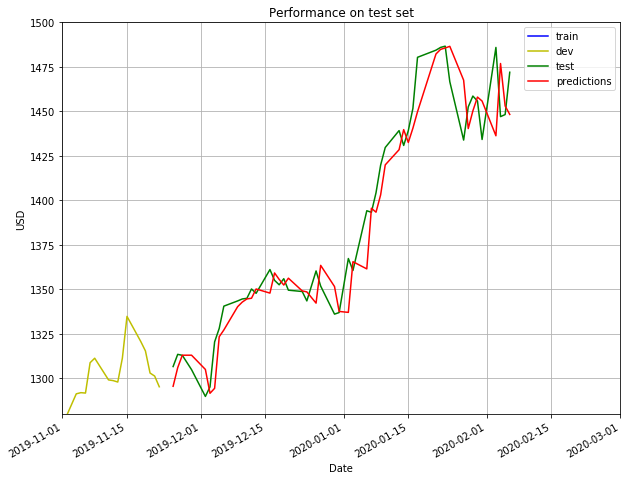

In [35]:
# Plot adjusted close over time, for test set only
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
ax = train.plot(x='Date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='Date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='Date', y='adj_close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='Date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("Date")
ax.set_ylabel("USD")
ax.set_xlim([date(2019, 11, 1), date(2020, 3, 1)])
ax.set_ylim([1280, 1500])
ax.set_title("Performance on test set")

Similar to valid set, the predictions capture turns in direction with a slight lag

(1280, 1500)

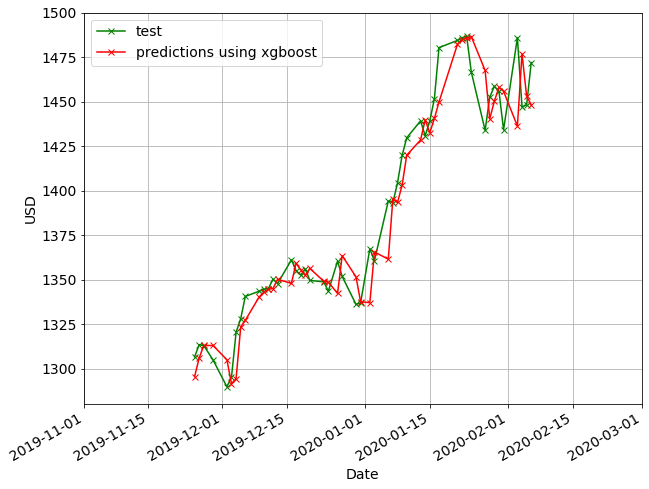

In [58]:
# Plot adjusted close over time, only for test set
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
matplotlib.rcParams.update({'font.size': 14})

ax = test.plot(x='Date', y='adj_close', style='gx-', grid=True)
ax = est_df.plot(x='Date', y='est', style='rx-', grid=True, ax=ax)
ax.legend(['test', 'predictions using xgboost'], loc='upper left')
ax.set_xlabel("Date")
ax.set_ylabel("USD")
ax.set_xlim([date(2019, 11, 1), date(2020, 3, 1)])
ax.set_ylim([1280, 1500])

- save stock price prediction results

In [ ]:
# Save as csv
test_xgboost = est_df
test_xgboost.to_csv("./out/test_xgboost.csv", index=False)

In [36]:
est_df.to_csv("./out/train_xgboost.csv", index=False)

In [ ]:
test_xgboost.head()

# Findings
* By scaling the features properly, we can get good results for our predictions
* RMSE and MAPE changed very little with hyperparameter tuning
* The final RMSE and MAPE for test set are 1.162 and 0.58% respectively

# Model Pickling

- train separate model for Pickling

In [ ]:
# model = XGBRegressor(seed=100,
#                          n_estimators=n_estimators_opt,
#                          max_depth=max_depth_opt,
#                          learning_rate=learning_rate_opt,
#                          min_child_weight=min_child_weight_opt,
#                          subsample=subsample_opt,
#                          colsample_bytree=colsample_bytree_opt,
#                          colsample_bylevel=colsample_bylevel_opt,
#                          gamma=gamma_opt)

# # Train the model
# model.fit(X_train_cv_scaled, y_train_cv_scaled)

- train model with hardcoded hyperparams to cut tuning time

In [32]:
model = XGBRegressor(seed=100,
                     n_estimators=270,
                     max_depth=3,
                     learning_rate=0.3,
                     min_child_weight=13,
                     subsample=0.4,
                     colsample_bytree=1,
                     colsample_bylevel=1,
                     gamma=0.1)

# Train the model
model.fit(X_train_cv_scaled, y_train_cv_scaled)

[21:14:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0.1,
             importance_type='gain', learning_rate=0.3, max_delta_step=0,
             max_depth=3, min_child_weight=13, missing=None, n_estimators=270,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=100,
             silent=None, subsample=0.4, verbosity=1)

- Model Pickling

In [53]:
# save model to pkl
joblib.dump(model, './api/xgboost_model.pkl')

['./api/model.pkl']

- model columns pickling

In [54]:
model_columns = list(X_train_cv_scaled.columns)
joblib.dump(model_columns, './api/xgboost_model_columns.pkl')

['./api/model_columns.pkl']

In [ ]:
# unserializing

# model = joblib.load("model.pkl")

# Post Processing for Engineering

In [62]:
# feed in a 1608-dimensional feature vector to the model to generate predicted price
len(X_train_cv_scaled.iloc[0, :].to_list())

1608

In [68]:
type(X_train_cv_scaled.iloc[0])

pandas.core.series.Series

- how to output one feature to json file

In [74]:
X_train_cv_scaled.iloc[0].to_frame().transpose()

,adj_close_lag_1,adj_close_lag_2,range_hl_lag_1,range_hl_lag_2,range_oc_lag_1,range_oc_lag_2,volume_lag_1,volume_lag_2,0_lag1,1_lag1,...,num_pos_VB_lag2,num_pos_NN_lag2,num_neg_JJ_lag2,num_neg_RB_lag2,num_neg_VB_lag2,num_neg_NN_lag2,total_score_JJ_lag2,total_score_RB_lag2,total_score_VB_lag2,total_score_NN_lag2
0,-1.335763,-1.065376,0.079093,2.155842,0.598046,2.214737,1.00078,1.085944,-1.954738,-14.44165,...,3.998121,55.419917,53.80289,42.127785,0.0,59.779481,23.410036,4.487775,1.999061,9.4315


In [132]:
X_train_cv_scaled.iloc[0].to_frame().transpose().to_json(orient='records')

'[{"adj_close_lag_1":-1.335762949,"adj_close_lag_2":-1.0653761979,"range_hl_lag_1":0.0790925831,"range_hl_lag_2":2.155841619,"range_oc_lag_1":0.5980460874,"range_oc_lag_2":2.2147373628,"volume_lag_1":1.0007798471,"volume_lag_2":1.0859438241,"0_lag1":-1.954737843,"1_lag1":-14.4416495832,"2_lag1":63.646112391,"3_lag1":-10.7318359413,"4_lag1":39.5541503289,"5_lag1":-40.8635897857,"6_lag1":-10.2723266565,"7_lag1":47.8806752467,"8_lag1":-21.6208396538,"9_lag1":-11.5684434741,"10_lag1":33.5477757688,"11_lag1":-26.6964357772,"12_lag1":14.7695554053,"13_lag1":43.0216274792,"14_lag1":-26.843595895,"15_lag1":50.1339859631,"16_lag1":-23.9534223941,"17_lag1":18.9247636417,"18_lag1":-5.5561156786,"19_lag1":-5.8334900182,"20_lag1":46.102324472,"21_lag1":-8.6694253703,"22_lag1":9.1622594302,"23_lag1":7.7260197855,"24_lag1":16.4982697468,"25_lag1":8.232287933,"26_lag1":6.9405457677,"27_lag1":-15.6735508817,"28_lag1":-49.121426865,"29_lag1":14.8955501645,"30_lag1":28.3543281782,"31_lag1":29.9791896484,

In [133]:
X_train_cv_scaled.iloc[0].to_frame().transpose().to_json(r'./json/test.json')

In [39]:
X_train_cv_scaled.iloc[15].to_frame().transpose().to_json(r'./json/feature16.json')

In [143]:
math.sqrt(scaler.var_[0]), scaler.mean_[0], cv['adj_close_std'], cv['adj_close_mean']

(50.76488554752878,
 1160.3414582052978,
 153     3.754779
 154     5.840709
 155     1.520297
 156     2.305175
 157     4.454721
 158     6.208332
 159     2.899120
 160    10.797534
 161    19.629291
 162     3.627461
 163    11.525875
 164     4.306256
 165     9.828801
 166    20.131310
 167     7.919561
 168    14.969482
 169     0.933343
 170    13.116865
 171     9.319706
 172     4.497189
 173     4.794118
 174     1.195056
 175    18.292849
 176     0.445481
 177     6.667968
 178     5.359838
 179     0.466715
 180     2.368790
 181    11.547023
 182     1.315208
 183     2.927433
 184    17.585742
 185    19.360587
 186     0.940421
 187     0.834424
 188     9.637869
 189    12.466296
 190     0.466715
 191     0.162620
 192    12.063196
 193     1.774845
 194     8.612599
 195     0.275695
 196     0.565720
 197     9.517630
 198    16.553394
 199    10.019734
 200     3.705232
 201     8.775133
 202     1.202133
 Name: adj_close_std, dtype: float64,
 153    1236.905029
 

In [74]:
# Do prediction on train set
est_scaled = model.predict(X_train_scaled)

# recover back to unscaled
est_train = est_scaled * math.sqrt(scaler.var_[0]) + scaler.mean_[0]


# Do prediction on valid set
est_scaled = model.predict(X_cv_scaled)
cv['est_scaled'] = est_scaled
cv['est'] = cv['est_scaled'] * cv['adj_close_std'] + cv['adj_close_mean']

est_cv = cv['est']

# hardcode hyperparams for training since we already have the hyperparams
rmse, mape, est_test = train_pred_eval_model(X_train_cv_scaled, 
                             y_train_cv_scaled, 
                             X_sample_scaled, 
                             y_sample, 
                             test['adj_close_mean'],
                             test['adj_close_std'],
                             seed=100,
                             n_estimators=270, 
                             max_depth=3, 
                             learning_rate=0.3, 
                             min_child_weight=13, 
                             subsample=0.4, 
                             colsample_bytree=1, 
                             colsample_bylevel=1, 
                             gamma=0.1)

/Users/frostace/.conda/envs/bert_env/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/frostace/.conda/envs/bert_env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


[14:54:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [75]:
len(est_train), len(est_cv), len(est_test)

(151, 50, 50)

In [76]:
mydata = price_feature[['Date', 'adj_close']]

In [82]:
mydata["value1"] = list(est_train) + est_cv.to_list() + est_test.to_list()

/Users/frostace/.conda/envs/bert_env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [84]:
mydata.iloc[0][0]

Timestamp('2019-02-08 00:00:00')

In [85]:
real_pred_251d = mydata.rename(columns={"Date": "date", "adj_close": "value0"})

In [86]:
real_pred_251d["date"] = real_pred_251d.apply(lambda x: x[0].to_pydatetime().date().isoformat(), axis=1)

In [87]:
real_pred_251d.iloc[:150, :].to_json(orient="records")

'[{"date":"2019-02-08","value0":1095.060059,"value1":1097.4630126953},{"date":"2019-02-11","value0":1095.01001,"value1":1085.2906494141},{"date":"2019-02-12","value0":1121.369995,"value1":1104.2950439453},{"date":"2019-02-13","value0":1120.160034,"value1":1121.162109375},{"date":"2019-02-14","value0":1121.670044,"value1":1131.9459228516},{"date":"2019-02-15","value0":1113.650024,"value1":1125.4329833984},{"date":"2019-02-19","value0":1118.560059,"value1":1113.5280761719},{"date":"2019-02-20","value0":1113.800049,"value1":1131.1976318359},{"date":"2019-02-21","value0":1096.969971,"value1":1104.4798583984},{"date":"2019-02-22","value0":1110.369995,"value1":1111.8536376953},{"date":"2019-02-25","value0":1109.400024,"value1":1115.7183837891},{"date":"2019-02-26","value0":1115.130005,"value1":1119.4855957031},{"date":"2019-02-27","value0":1116.050049,"value1":1116.3596191406},{"date":"2019-02-28","value0":1119.920044,"value1":1112.7442626953},{"date":"2019-03-01","value0":1140.98999,"value1

In [91]:
real_pred_251d.drop(['value1'], axis=1)

,date,value0
2,2019-02-08,1095.060059
3,2019-02-11,1095.010010
4,2019-02-12,1121.369995
5,2019-02-13,1120.160034
6,2019-02-14,1121.670044
...,...,...
248,2020-01-31,1434.229980
249,2020-02-03,1485.939941
250,2020-02-04,1447.069946
251,2020-02-05,1448.229980


In [93]:
real_price_251d = real_pred_251d.drop(['value1'], axis=1)
real_price_251d.set_index("date", inplace=True)
real_price_251d.to_json(r'./json/real_price.json', orient="index")

In [36]:
X_train_cv_scaled.head()

,adj_close_lag_1,adj_close_lag_2,range_hl_lag_1,range_hl_lag_2,range_oc_lag_1,range_oc_lag_2,volume_lag_1,volume_lag_2,0_lag1,1_lag1,...,num_pos_VB_lag2,num_pos_NN_lag2,num_neg_JJ_lag2,num_neg_RB_lag2,num_neg_VB_lag2,num_neg_NN_lag2,total_score_JJ_lag2,total_score_RB_lag2,total_score_VB_lag2,total_score_NN_lag2
0,-1.335763,-1.065376,0.079093,2.155842,0.598046,2.214737,1.000780,1.085944,-1.954738,-14.441650,...,3.998121,55.419917,53.802890,42.127785,0.0,59.779481,23.410036,4.487775,1.999061,9.431500
1,-1.393679,-1.329108,-0.810192,0.068295,-0.585484,0.580271,-0.528033,0.990199,5.805648,-10.267495,...,2.000000,18.000000,37.000000,8.000000,2.0,12.000000,5.026641,2.214286,0.675000,6.566667
2,-1.394473,-1.387377,-0.710699,-0.810669,0.290548,-0.588707,-0.544757,-0.535736,12.109340,-1.015043,...,3.000000,24.000000,16.000000,1.000000,1.0,12.000000,8.259351,2.350000,0.900000,9.300000
3,-0.976197,-1.388176,0.162134,-0.712331,-1.155770,0.276553,0.313366,-0.552429,6.390824,-82.130350,...,2.000000,22.000000,20.000000,4.000000,0.0,10.000000,9.891429,2.069444,1.600000,8.600000
4,-0.995397,-0.967355,-0.279090,0.150373,0.543722,-1.151981,-0.569054,0.304079,0.176889,-9.644508,...,3.419543,45.266850,134.814683,4.000000,1.0,12.000000,16.288132,10.861708,1.267817,18.083712


In [35]:
X_sample_scaled.head()

,adj_close_lag_1,adj_close_lag_2,range_hl_lag_1,range_hl_lag_2,range_oc_lag_1,range_oc_lag_2,volume_lag_1,volume_lag_2,0_lag1,1_lag1,...,num_pos_VB_lag2,num_pos_NN_lag2,num_neg_JJ_lag2,num_neg_RB_lag2,num_neg_VB_lag2,num_neg_NN_lag2,total_score_JJ_lag2,total_score_RB_lag2,total_score_VB_lag2,total_score_NN_lag2
0,-0.707107,0.707107,-0.707107,0.707107,0.707107,-0.707107,0.707107,-0.707107,10.068995,-12.271092,...,2.0,23.000000,15.000000,5.0,1.0,13.0,2.535808,1.790476,1.375000,9.114286
1,0.707107,-0.707107,-0.707107,0.707107,-0.707107,0.707107,-0.707107,0.707107,5.379677,-6.949449,...,1.0,26.825376,8.000000,0.0,0.0,13.0,42.680469,4.332802,0.136364,10.834766
2,0.707107,-0.707107,-0.707107,0.707107,0.707107,-0.707107,0.707107,-0.707107,5.660011,-10.634193,...,2.0,23.000000,15.000000,1.0,0.0,18.0,4.421104,0.366667,1.000000,6.200000
3,-0.707107,0.707107,-0.707107,0.707107,0.707107,-0.707107,-0.707107,0.707107,-0.089607,-20.038719,...,2.0,26.000000,15.000000,3.0,1.0,14.0,3.058810,0.666667,0.450000,9.700000
4,-0.707107,0.707107,-0.707107,0.707107,0.707107,-0.707107,-0.707107,0.707107,4.908326,-4.360096,...,2.0,26.438785,23.871174,3.0,1.0,14.0,29.343074,1.884888,0.800000,10.769393


In [108]:
_all_feature = pd.concat([train_cv_feature_with_price_and_twitter, test_feature_with_price_and_twitter], ignore_index=True).drop(['month', 'adj_close'], axis=1).rename(columns={"Date": "date"})

In [109]:
_all_feature["date"] = _all_feature.apply(lambda x: x[0].isoformat(), axis=1)

In [110]:
_all_feature.head()

,date,adj_close_lag_1,range_hl_lag_1,range_oc_lag_1,volume_lag_1,adj_close_lag_2,range_hl_lag_2,range_oc_lag_2,volume_lag_2,0_lag1,...,num_pos_VB_lag2,num_pos_NN_lag2,num_neg_JJ_lag2,num_neg_RB_lag2,num_neg_VB_lag2,num_neg_NN_lag2,total_score_JJ_lag2,total_score_RB_lag2,total_score_VB_lag2,total_score_NN_lag2
0,2019-02-08,-1.335763,0.079093,0.598046,1.000780,-1.065376,2.155842,2.214737,1.085944,-1.954738,...,3.998121,55.419917,53.802890,42.127785,0.0,59.779481,23.410036,4.487775,1.999061,9.431500
1,2019-02-11,-1.393679,-0.810192,-0.585484,-0.528033,-1.329108,0.068295,0.580271,0.990199,5.805648,...,2.000000,18.000000,37.000000,8.000000,2.0,12.000000,5.026641,2.214286,0.675000,6.566667
2,2019-02-12,-1.394473,-0.710699,0.290548,-0.544757,-1.387377,-0.810669,-0.588707,-0.535736,12.109340,...,3.000000,24.000000,16.000000,1.000000,1.0,12.000000,8.259351,2.350000,0.900000,9.300000
3,2019-02-13,-0.976197,0.162134,-1.155770,0.313366,-1.388176,-0.712331,0.276553,-0.552429,6.390824,...,2.000000,22.000000,20.000000,4.000000,0.0,10.000000,9.891429,2.069444,1.600000,8.600000
4,2019-02-14,-0.995397,-0.279090,0.543722,-0.569054,-0.967355,0.150373,-1.151981,0.304079,0.176889,...,3.419543,45.266850,134.814683,4.000000,1.0,12.000000,16.288132,10.861708,1.267817,18.083712


In [111]:
toy = _all_feature.iloc[:4, :4]

In [134]:
toy

,adj_close_lag_1,range_hl_lag_1,range_oc_lag_1
date,,,
2019-02-08,-1.335763,0.079093,0.598046
2019-02-11,-1.393679,-0.810192,-0.585484
2019-02-12,-1.394473,-0.710699,0.290548
2019-02-13,-0.976197,0.162134,-1.155770


In [112]:
toy.set_index("date", inplace=True)

In [131]:
toy.to_json(orient="index")

'{"2019-02-08":{"adj_close_lag_1":-1.335762949,"range_hl_lag_1":0.0790925831,"range_oc_lag_1":0.5980460874},"2019-02-11":{"adj_close_lag_1":-1.3936790285,"range_hl_lag_1":-0.8101916823,"range_oc_lag_1":-0.5854837516},"2019-02-12":{"adj_close_lag_1":-1.3944731982,"range_hl_lag_1":-0.7106991453,"range_oc_lag_1":0.2905475403},"2019-02-13":{"adj_close_lag_1":-0.9761970405,"range_hl_lag_1":0.1621341364,"range_oc_lag_1":-1.1557702234}}'

In [68]:
_all_feature.set_index("date", inplace=True)

In [69]:
_all_feature.to_json(r'./json/all_feature.json', orient="index")

In [96]:
real_price_251d.index.to_list()

['2019-02-08',
 '2019-02-11',
 '2019-02-12',
 '2019-02-13',
 '2019-02-14',
 '2019-02-15',
 '2019-02-19',
 '2019-02-20',
 '2019-02-21',
 '2019-02-22',
 '2019-02-25',
 '2019-02-26',
 '2019-02-27',
 '2019-02-28',
 '2019-03-01',
 '2019-03-04',
 '2019-03-05',
 '2019-03-06',
 '2019-03-07',
 '2019-03-08',
 '2019-03-11',
 '2019-03-12',
 '2019-03-13',
 '2019-03-14',
 '2019-03-15',
 '2019-03-18',
 '2019-03-19',
 '2019-03-20',
 '2019-03-21',
 '2019-03-22',
 '2019-03-25',
 '2019-03-26',
 '2019-03-27',
 '2019-03-28',
 '2019-03-29',
 '2019-04-01',
 '2019-04-02',
 '2019-04-03',
 '2019-04-04',
 '2019-04-05',
 '2019-04-08',
 '2019-04-09',
 '2019-04-10',
 '2019-04-11',
 '2019-04-12',
 '2019-04-15',
 '2019-04-16',
 '2019-04-17',
 '2019-04-18',
 '2019-04-22',
 '2019-04-23',
 '2019-04-24',
 '2019-04-25',
 '2019-04-26',
 '2019-04-29',
 '2019-04-30',
 '2019-05-01',
 '2019-05-02',
 '2019-05-03',
 '2019-05-06',
 '2019-05-07',
 '2019-05-08',
 '2019-05-09',
 '2019-05-10',
 '2019-05-13',
 '2019-05-14',
 '2019-05-

In [135]:
toy2 = {
    "adj_close_lag_1": 0.8992245826,
    "range_hl_lag_1": -0.6029645109,
    "range_oc_lag_1": -0.5986263234,
    "volume_lag_1": -0.1720988869,
    "adj_close_lag_2": 0.8347069303,
    "range_hl_lag_2": 0.0682948599,
    "range_oc_lag_2": -0.7522313921,
    "volume_lag_2": 0.4880103085
}
toy2 = pd.DataFrame(toy2.items())

In [142]:
toy_middle = toy2.iloc[:, 1].to_frame().transpose()
toy_middle.columns = toy2[0].to_list()
toy_middle.head()

,adj_close_lag_1,range_hl_lag_1,range_oc_lag_1,volume_lag_1,adj_close_lag_2,range_hl_lag_2,range_oc_lag_2,volume_lag_2
1,0.899225,-0.602965,-0.598626,-0.172099,0.834707,0.068295,-0.752231,0.48801


In [145]:
train_feature_with_price_and_twitter

,Date,month,adj_close,adj_close_lag_1,range_hl_lag_1,range_oc_lag_1,volume_lag_1,adj_close_lag_2,range_hl_lag_2,range_oc_lag_2,...,num_pos_VB_lag2,num_pos_NN_lag2,num_neg_JJ_lag2,num_neg_RB_lag2,num_neg_VB_lag2,num_neg_NN_lag2,total_score_JJ_lag2,total_score_RB_lag2,total_score_VB_lag2,total_score_NN_lag2
0,2019-02-08,2,-1.285956,-1.199711,0.069291,0.572300,0.855888,-0.861797,2.089417,2.155215,...,3.998121,55.419917,53.802890,42.127785,0.0,59.779481,23.410036,4.487775,1.999061,9.431500
1,2019-02-11,2,-1.286942,-1.271851,-0.800118,-0.595272,-0.536032,-1.189908,0.054802,0.545097,...,2.000000,18.000000,37.000000,8.000000,2.0,12.000000,5.026641,2.214286,0.675000,6.566667
2,2019-02-12,2,-0.767685,-1.272840,-0.702849,0.268947,-0.551258,-1.262400,-0.801875,-0.606466,...,3.000000,24.000000,16.000000,1.000000,1.0,12.000000,8.259351,2.350000,0.900000,9.300000
3,2019-02-13,2,-0.791520,-0.751835,0.150476,-1.157869,0.230027,-1.263394,-0.706031,0.245904,...,2.000000,22.000000,20.000000,4.000000,0.0,10.000000,9.891429,2.069444,1.600000,8.600000
4,2019-02-14,2,-0.761775,-0.775750,-0.280887,0.518708,-0.573380,-0.739847,0.134798,-1.161350,...,3.419543,45.266850,134.814683,4.000000,1.0,12.000000,16.288132,10.861708,1.267817,18.083712
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146,2019-09-09,9,0.868092,0.899731,-1.184771,0.377840,-0.541347,1.047879,0.407791,-1.611404,...,1.000000,56.376043,11.000000,3.000000,1.0,26.027405,37.772545,4.434799,0.300000,22.349892
147,2019-09-10,9,0.899412,0.889452,1.215094,0.065858,0.032946,0.919774,-1.180896,0.353303,...,0.000000,24.000000,12.000000,0.000000,0.0,15.000000,3.248377,0.464286,0.000000,9.666667
148,2019-09-11,9,1.178543,0.920878,-0.389555,-0.836382,-0.271294,0.909446,1.183826,0.045599,...,0.000000,27.000000,20.000000,2.000000,1.0,16.000000,8.954383,2.074444,-0.600000,10.252381
149,2019-09-12,9,1.455899,1.200949,0.278601,-1.347139,-0.203925,0.941025,-0.397324,-0.844271,...,1.000000,25.000000,13.000000,3.000000,0.0,16.000000,1.270833,1.538889,0.800000,9.400000
